In [1]:
import sys
sys.path.append(f'/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/mae')

In [3]:
import models_lib
import torchvision.transforms as transforms
import torch
import numpy as np
import timm
import matplotlib.pyplot as plt
from dataset_mae import MAEDataset


In [4]:
MEAN_CLIPORT = [0.48145466, 0.4578275, 0.40821073]
STD_CLIPORT = [0.26862954, 0.26130258, 0.27577711]
TEST_PATH = '/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/data_hdf5/mix_seen_v2_full.hdf5'
MODEL = 'mae_robot_lang'
CHECKPOINT = '/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/output_mae_robot_lang_mix_v2_full/checkpoint-60.pth'
device = 'cuda'

In [5]:
def get_fix_transform():
    trasform_fix = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN_CLIPORT, std=STD_CLIPORT)])
    return trasform_fix

def generate_token(text_processor, lang, device):
    if type(lang) is str:
        decoded_strings = [lang]
    else:
        decoded_strings = [s.decode('ascii') for s in lang]
    processed_lang = text_processor(text=decoded_strings, padding="max_length", return_tensors='pt')
    processed_lang = processed_lang.to(device)
    return processed_lang

In [6]:
# load data and model
transform_train = get_fix_transform()
dataset_vis = MAEDataset(transform=transform_train, data_path=TEST_PATH)
model = models_lib.__dict__[MODEL](norm_pix_loss=False)
model.to(device)
checkpoint = torch.load(CHECKPOINT, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

Length of the dataset:  81766
Loaded CLIP text model: openai/clip-vit-base-patch32


/tmp/ipykernel_3008990/130817195.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT, map_location='cpu')


_IncompatibleKeys(missing_keys=[], unexpected_keys=['clip_text.text_model.embeddings.position_ids'])

In [7]:
from transformers import AutoTokenizer
text_processor = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [18]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/test_new2.png')
img_input = img_input.unsqueeze(0)

Tensor moved to GPU


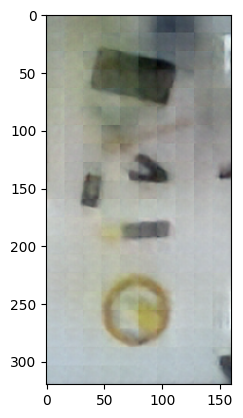

In [17]:
img_input=img_input[:,:3,:,:]
input_lang =  "put the fork on the black phone"

lang_processed =generate_token(text_processor, input_lang, device)
with torch.no_grad():
    
    loss, predict, mask = model(img_input, img_input, None, None, lang_processed, mask_ratio=1.00)
    predict = model.unpatchify(predict)
    predict = predict.detach().cpu()
    predict = predict[0]
    predict = (predict - predict.min()
            ) / (predict.max() - predict.min())
    predict = predict.permute(1, 2, 0).numpy()

plt.imshow(predict)

In [ ]:
from torch.utils.data import DataLoader, Subset
import cv2

def get_random_batch(idx):
    subset_indices = [idx]
    subset = Subset(dataset_vis, subset_indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)
    batch = next(iter(subset_loader))
    return batch

def show_image_relevance(image_relevance, image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)    
    image = (image - image.min()) / (image.max() - image.min())
    image = image[0].permute(1, 2, 0).cpu().numpy()    
    axs[0].imshow(image);
    axs[0].axis('off');
    
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image_relevance = image_relevance[0].permute(1, 2, 0).data.cpu().numpy()

    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [ ]:
TESTSET_IDX = [0,716,1216,1716,2205,2694,2928,3205,3305,3535,3757,3924,4091,5015,5933,6570,7207,7920,8633]

In [ ]:
batch = get_random_batch(80000)

img1, img2, lang, pick, place = batch
img1 = img1.to(device, non_blocking=True).float()
img2 = img2.to(device, non_blocking=True).float()
pick = pick.to(device, non_blocking=True).float()
place = place.to(device, non_blocking=True).float()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')


original lang is (b'move the purple ring to the middle of the stand',)
Please input your lang ...


(-0.5, 159.5, 319.5, -0.5)

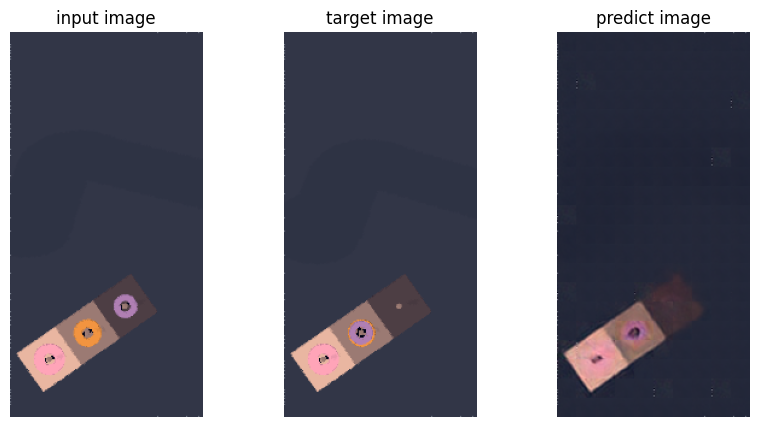

In [47]:
img1, img2, lang, pick, place = batch
img1 = img1.to(device, non_blocking=True).float()
img2 = img2.to(device, non_blocking=True).float()
pick = pick.to(device, non_blocking=True).float()
place = place.to(device, non_blocking=True).float()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')
print(f"original lang is {lang}")
print("Please input your lang ...")
input_lang = input()

lang_input = input_lang if input_lang else lang
lang_processed = generate_token(text_processor, lang_input, device)
    
loss, predict, mask = model(img1, img2, pick, place, lang_processed, mask_ratio=0.95)
predict = model.unpatchify(predict)
predict = predict.detach().cpu()
predict = predict[0]
predict = (predict - predict.min()) / (predict.max() - predict.min())
predict = predict.permute(1, 2, 0).numpy()

plt.subplot(1, 3, 3)
plt.imshow(predict)
plt.title('predict image')
plt.axis('off')



In [42]:
img1.shape

torch.Size([1, 3, 320, 160])

In [30]:
relevance = model.show_relevance_map(img1,lang_processed)
show_image_relevance(relevance, img1)

ModuleAttributeError: 'MAERobotLang' object has no attribute 'show_relevance_map'

In [21]:
from cliport.real_dataset import RealDataset
task = "pack_objects"
batch_size=1
val_ds = RealDataset(task_name=task,data_type='test_unseen', augment=False)
val_ds = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
val_ds = iter(val_ds)

Loading real new dataset...


In [22]:
img1 = batch[0]['img'][:,:,:,:3]
img1 = img1.permute(0,3,1,2)
img1

TypeError: new(): invalid data type 'str'

original lang is pack the soft ball in the brown box
Please input your lang ...


(-0.5, 159.5, 319.5, -0.5)

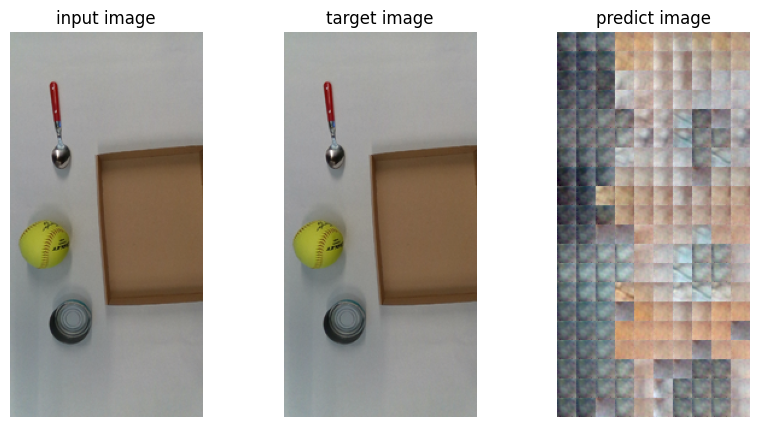

In [27]:
batch = next(val_ds)

lang_input = batch[0]['lang_goal'][0]
print(f"original lang is {lang_input}")
print("Please input your lang ...")
input_lang = input()
lang_input = input_lang if input_lang else lang
lang_processed = generate_token(text_processor, lang_input, device)
img1 = batch[0]['img'][:,:,:,:3]
img1 = img1.permute(0,3,1,2)
pick = 0
place = 0
img1 = img1.to('cuda').float()
img2 = img1
loss, predict, mask = model(img1, img2, pick, place, lang_processed, mask_ratio=0.95)
predict = model.unpatchify(predict)
predict = predict.detach().cpu()
predict = predict[0]
predict = (predict - predict.min()) / (predict.max() - predict.min())
predict = predict.permute(1, 2, 0).numpy()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predict)
plt.title('predict image')
plt.axis('off')

In [10]:
import torch
from torchvision import transforms
from PIL import Image
def load_image_to_tensor(image_path):
    """
    Load an image from the specified path and convert it to a PyTorch tensor.

    Args:
        image_path (str): The path to the image file.

    Returns:
        torch.Tensor: The image converted to a PyTorch tensor.
    """
    # Define the transform to convert the image to a tensor
    transform = transforms.Compose([
        transforms.Resize((320, 160)),
        transforms.ToTensor()
    ])

    # Load the image
    image = Image.open(image_path)

    # Apply the transform to the image
    image_tensor = transform(image)

    # Optional: Move the tensor to GPU if available
    if torch.cuda.is_available():
        image_tensor = image_tensor.to('cuda')
        print('Tensor moved to GPU')
    
    return image_tensor

Tensor moved to GPU
the man wearing glasses


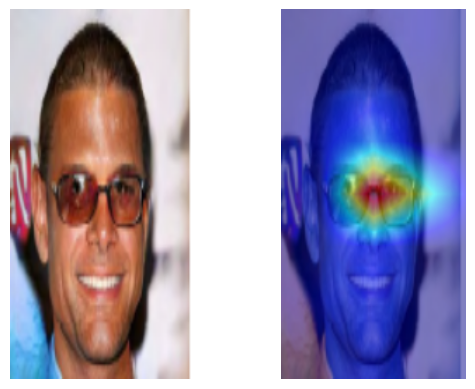

In [68]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/glasses.png')
img_input = img_input.unsqueeze(0)
input_lang = input()
lang_processed =generate_token(text_processor, input_lang, device)
relevance = model.show_relevance_map(img_input,lang_processed)
show_image_relevance(relevance, img_input)

Tensor moved to GPU
test


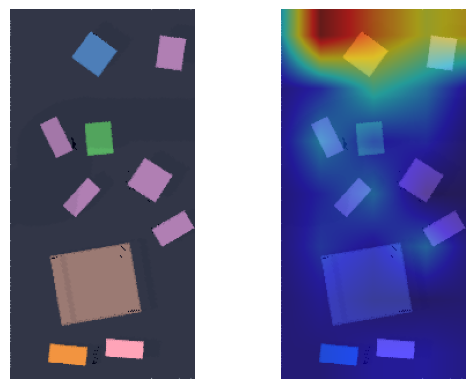

In [59]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/DiffPort/data_gt_real_images/real0.png')
img_input = img_input.unsqueeze(0)


In [14]:
img_input.shape

torch.Size([1, 3, 320, 160])

the red plate


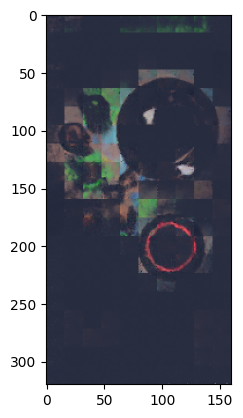

In [46]:
input_lang = input()
lang_processed = generate_token(text_processor, lang_input, device)

with torch.no_grad():
    
    loss, predict, mask = model(img_input, img_input, pick, place, lang_processed, mask_ratio=0.95)
    predict = model.unpatchify(predict)
    predict = predict.detach().cpu()
    predict = predict[0]
    predict = (predict - predict.min()
            ) / (predict.max() - predict.min())
    predict = predict.permute(1, 2, 0).numpy()

plt.imshow(predict)